In [30]:
import torch
from torch import nn

In [31]:
import matplotlib.pyplot as plt

In [32]:
torch.has_mps

True

In [33]:
device = "mps" if torch.has_mps else "cpu"

In [34]:
from pathlib import Path

In [35]:
data_path  =Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"


Random image path: data/pizza_steak_sushi/train/steak/3245622.jpg
Image class: steak
Image height: 262
Image width: 512


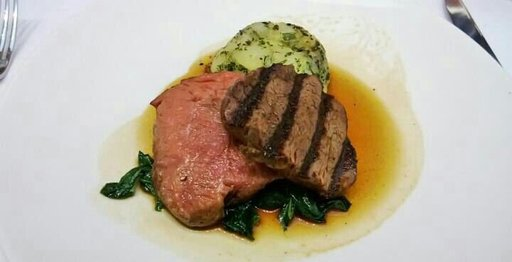

In [36]:
import random
from PIL import Image

random.seed(421)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [37]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [38]:
## Image Transformation 
data_transform = transforms.Compose([
    ## Resizing The Image ##
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
    transforms.ToTensor()

])

In [39]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


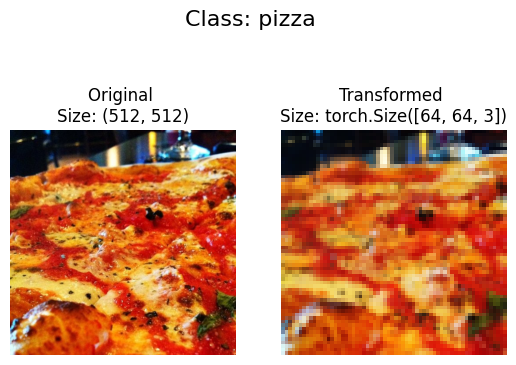

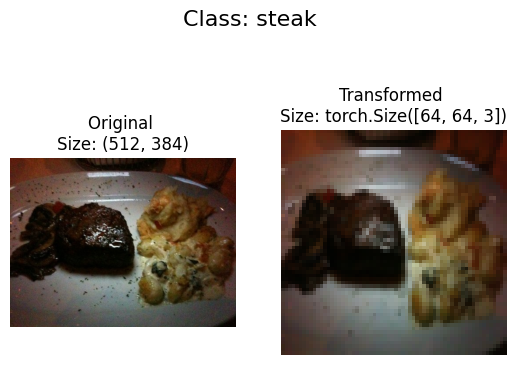

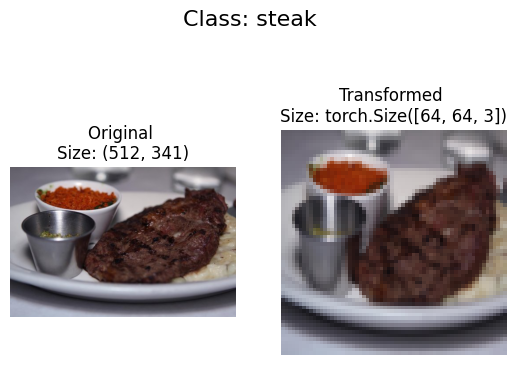

In [40]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [41]:
# Using Image Folder to create DataSets
from torchvision import datasets

In [42]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

In [43]:
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [44]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [45]:
class_dict = train_data.class_to_idx

In [46]:
class_name = train_data.classes

In [47]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [48]:
img, label = train_data[0][0], train_data[0][1]

In [49]:
img.shape

torch.Size([3, 64, 64])

In [50]:
img.shape

torch.Size([3, 64, 64])

In [51]:
img_permute = img.permute(1, 2, 0)

In [52]:
img_permute.shape

torch.Size([64, 64, 3])

Text(0.5, 1.0, 'pizza')

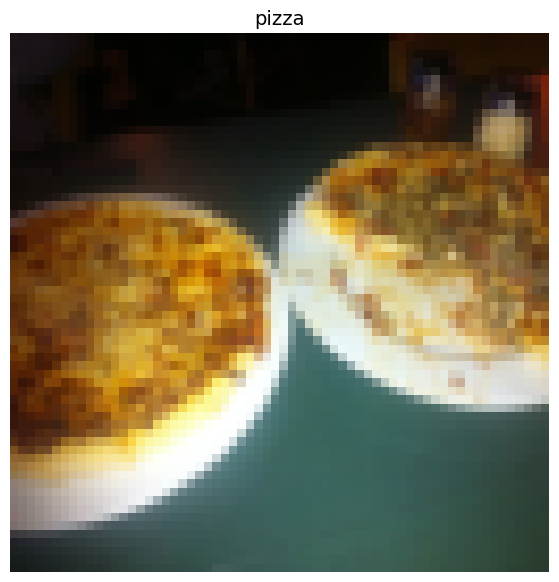

In [53]:
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_name[label], fontsize=14)

In [54]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x14e717910>,
 <torch.utils.data.dataloader.DataLoader at 0x14e717ac0>)

In [55]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Using Custom DataSet 

In [56]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [57]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['.DS_Store', 'pizza', 'steak', 'sushi']


In [70]:
class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None) -> None:

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        self.transform = transform

        self.classes = ['pizza', 'steak', 'sushi']
        self.class_to_idx = {'pizza': 0, 'steak': 1, 'sushi': 2}


    def load_image(self, index:int) -> Image.Image:
        """Open Image from path via index and returns it

        :param index: Index
        :type index: int

        :return: Image
        :rtype: Image.Image
        """

        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)
    

    ## Overriding this is required 
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        """Returns One Sample of data; (data  & Label)


        :param index: _description_
        :type index: int
        :return: _description_
        :rtype: Tuple[torch.Tensor, int]
        """

        img = self.load_image(index=index)

        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        
        else:
            return img, class_idx
        

In [71]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [72]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x14e5d2cd0>,
 <__main__.ImageFolderCustom at 0x14e5d2910>)

In [73]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [74]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [75]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [76]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

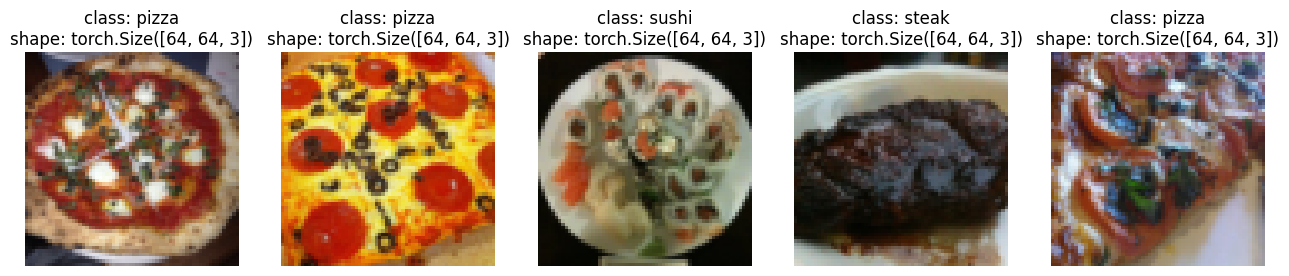

In [78]:
display_random_images(train_data_custom, 
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

## DataLoader

In [80]:
train_dataloader_cs = DataLoader(dataset=train_data_custom,
                                 batch_size=10,
                                 num_workers=0,
                                 shuffle=True)

test_dataloader_cs = DataLoader(dataset=test_data_custom,
                                batch_size=10,
                                num_workers=0,
                                shuffle=False)

In [82]:


# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_cs))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([10, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([10])


In [ ]:
## Image Transformation 
data_transform = transforms.Compose([
    ## Resizing The Image ##
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
    transforms.ToTensor()

])

In [84]:
transform_new = torch.nn.Sequential(
    transforms.Resize(size=(64, 64)),
    ## Horizontal Flip ##
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn Image into a torch Tensor
)

In [85]:
train_data_no_ts = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=None)

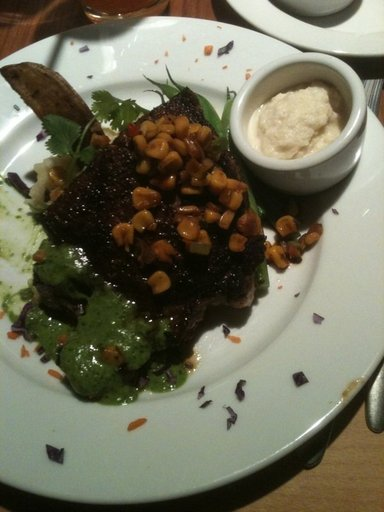

In [87]:
train_data_no_ts[0][0]

In [89]:
type(transform_new(train_data_no_ts[0][0]))

PIL.Image.Image

In [1]:
from torchvision import transforms

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()

])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])